In [1158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1159]:
# Import Datasets

# Import TRAIN dataset for modeling - Monthly Data 1996-2006
df_train = pd.read_csv('./data/clean/train.csv')

# Import TEST dataset for applying model on Unseen data - Monthly Data 2007-2009
df_test = pd.read_csv('./data/clean/test.csv')

print(df_train.shape)
print(df_test.shape)

(50292, 10)
(13716, 10)


In [1160]:
# Modify datasets to set index to datetime index - TRAIN
df_train.index = pd.to_datetime(df_train['year-month'])
df_train = df_train.drop(columns=['year-month'])

# Modify datasets to set index to datetime index - TRAIN
df_test.index = pd.to_datetime(df_test['year-month'])
df_test = df_test.drop(columns=['year-month'])

We will not need our **df_test** dataset until later in the analysis

In [1161]:
df_train.head()

,route,passengers,seat_capacity,num_of_flights,dist_miles,pop_origin,pop_dest,airfare,fuel_usd_pergallon
year-month,,,,,,,,,
1996-01-31,"Albany, NY - Chicago, IL",10985,18579,175,723.000000,825245,17287860,273.90,0.55
1996-01-31,"Albuquerque, NM - Chicago, IL",5203,8604,62,1119.500000,680994,17287860,156.16,0.55
1996-01-31,"Albuquerque, NM - Dallas, TX",43467,69323,494,573.714286,680994,8994450,89.76,0.55
1996-01-31,"Albuquerque, NM - Houston, TX",13017,22992,186,750.000000,680994,4268132,104.98,0.55
1996-01-31,"Albuquerque, NM - Las Vegas, NV",16010,29919,223,487.000000,680994,1044023,77.06,0.55


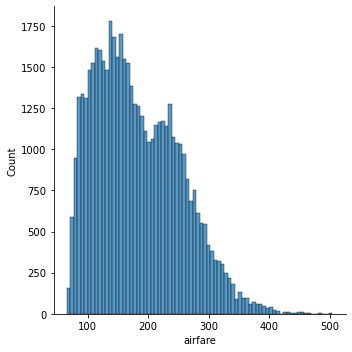

In [1162]:
# Look at distribution of all flights
sns.displot(df_train['airfare']);

### Benford

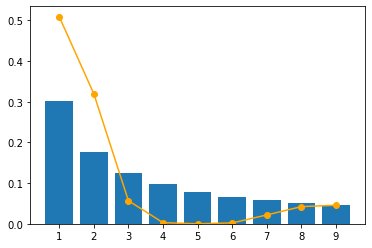

In [1163]:
# Looking at Benford's Law to see any irregularities
df_train['FIRST_DIGIT'] = df_train['airfare'].astype(str).apply(lambda x: x[0]).astype(int).copy()
df_train['FIRST_DIGIT'].value_counts()

digits = list(range(1,10))
benford = [np.log10(1 + 1 / d) for d in digits]

plt.bar(digits, benford, color='blue')
plt.xticks(digits);

percentages = df_train['FIRST_DIGIT'].value_counts(normalize=True).sort_index()
plt.bar(digits, benford)
plt.plot(percentages, color='orange', marker='o')
plt.xticks(digits);

# A clear majority of flights price between $100-$199, followed by $200-$299.  After this flights both $80-$89, $90-$99, or $300-$399 come next
df_train = df_train.drop(columns=['FIRST_DIGIT'])

In [1164]:
# top 5 routes by frequency
enter_year = 2006

df_train[str(enter_year)].groupby('route')[['passengers', 'seat_capacity', 'num_of_flights']].sum().sort_values(by=['num_of_flights'],
                                                                                                          ascending=False).head(10)

,passengers,seat_capacity,num_of_flights
route,,,
"Dallas, TX - Houston, TX",1597094,2247730,23903
"Boston, MA - New York, NY",1156125,1902661,20388
"New York, NY - Washington, DC",1097632,1826493,19902
"Chicago, IL - New York, NY",1599779,2021458,16755
"Boston, MA - Washington, DC",894740,1395717,15482
"Chicago, IL - Minneapolis, MN",1290563,1707621,14984
"Chicago, IL - Washington, DC",1307565,1809409,14541
"Atlanta, GA - Washington, DC",1284830,1766376,14522
"Atlanta, GA - Chicago, IL",1118470,1526132,14410


In [1165]:
# Which route do we want to look at?  Enter route and save as variable itinerary
itinerary = 'Dallas, TX - Houston, TX'

# Save the itinerary dataset as it's own dataframe
route = df_train[df_train['route'] == itinerary].copy()

# Save the itinerary dataset as it's own dataframe for later predictions
unseen_route = df_test[df_test['route'] == itinerary].copy()

print(route.shape)
print(unseen_route.shape)

(132, 9)
(36, 9)


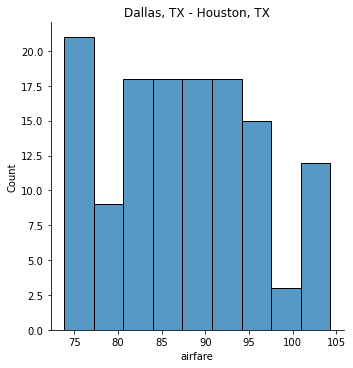

In [1166]:
sns.displot(route['airfare']).set(title=itinerary);

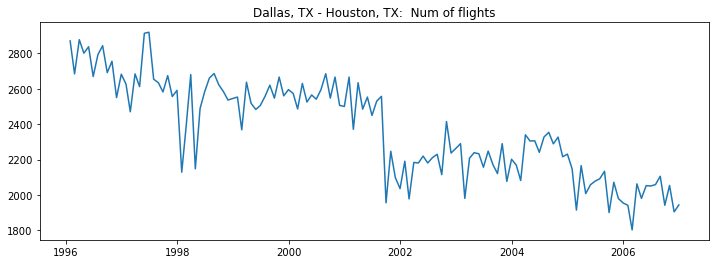

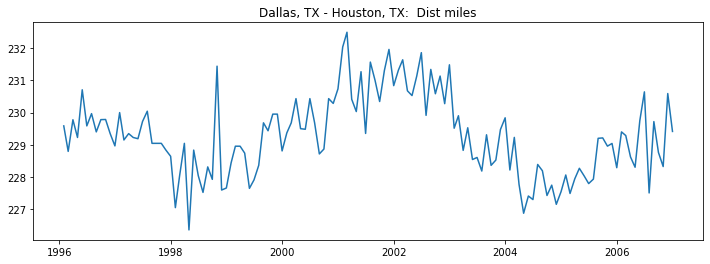

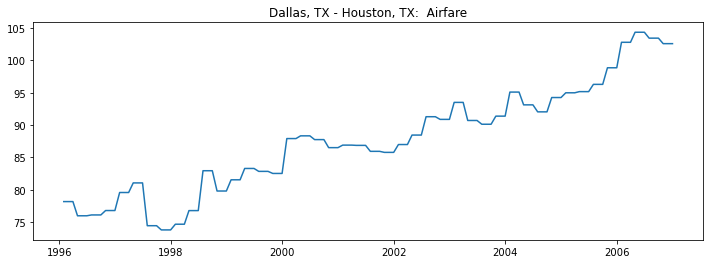

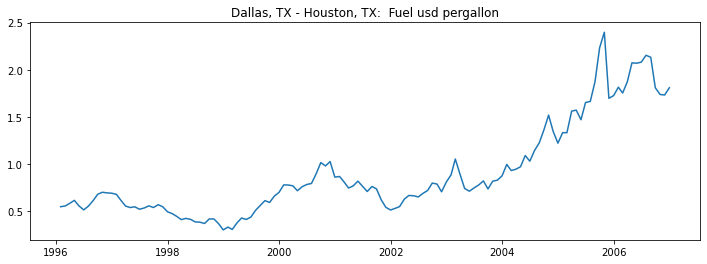

In [1167]:
for i in route[['num_of_flights', 'dist_miles', 'airfare', 'fuel_usd_pergallon']].columns:
    plt.figure(figsize=(12,4))
    plt.plot(route[i])
    plt.title(str(itinerary) + ":  " + i.replace('_', " ").capitalize())

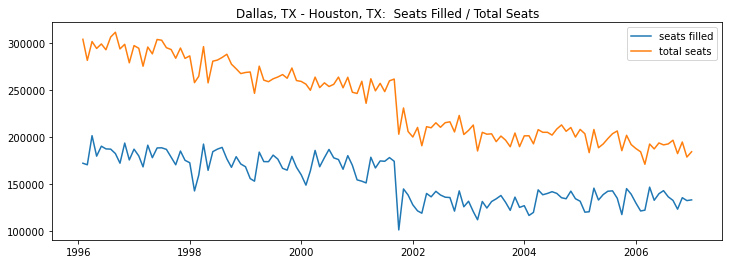

In [1168]:
plt.figure(figsize=(12, 4))
plt.plot(route['passengers'], label='seats filled')
plt.plot(route['seat_capacity'], label='total seats')
plt.legend()
plt.title(str(itinerary) + ":  " + 'Seats Filled / Total Seats');


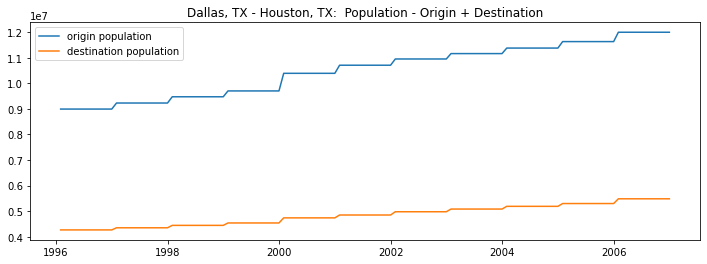

In [1169]:
plt.figure(figsize=(12, 4))
plt.plot(route['pop_origin'], label='origin population')
plt.plot(route['pop_dest'], label='destination population')
plt.legend()
plt.title(str(itinerary) + ":  " + 'Population - Origin + Destination');

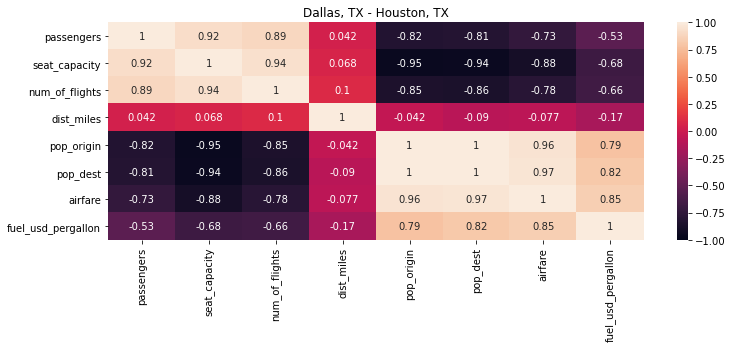

In [1170]:
plt.figure(figsize=(12, 4))
sns.heatmap(data = route.corr(), annot=True, vmin=-1.0, vmax=1.0).set(title=itinerary);

## .rolling( )

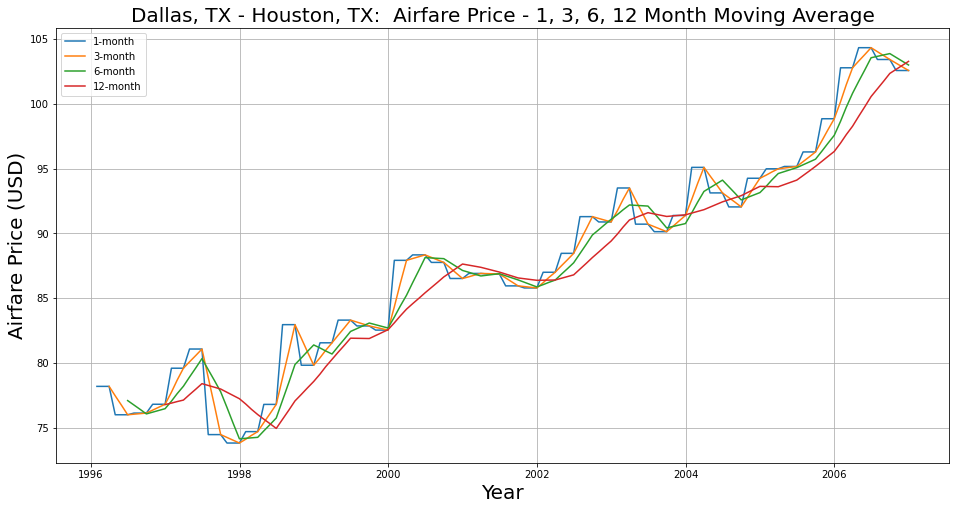

In [1171]:
plt.figure(figsize=(16,8))
plt.grid()
plt.xlabel('Year', size=20)
plt.ylabel('Airfare Price (USD)', size=20)
plt.plot(route['airfare'].rolling(1).mean(), label='1-month') # same as not having .rolling(1).mean()
plt.plot(route['airfare'].rolling(3).mean(), label='3-month')
plt.plot(route['airfare'].rolling(6).mean(), label='6-month')
plt.plot(route['airfare'].rolling(12).mean(), label='12-month')
plt.title(str(itinerary) + ":  " + 'Airfare Price - 1, 3, 6, 12 Month Moving Average', size=20)
plt.legend();

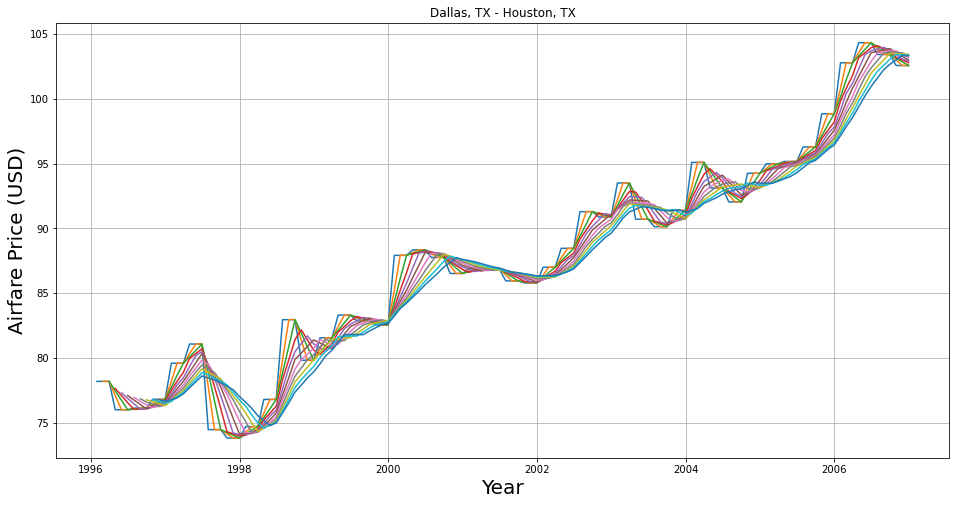

In [1172]:
plt.figure(figsize=(16,8))
plt.grid()
plt.xlabel('Year', size=20)
plt.ylabel('Airfare Price (USD)', size=20)
plt.xticks()
plt.title(str(itinerary))
for i in range(1, 12): # 1 month, 2 month....12 months
    plt.plot(route['airfare'].rolling(i).mean());

## .diff( )

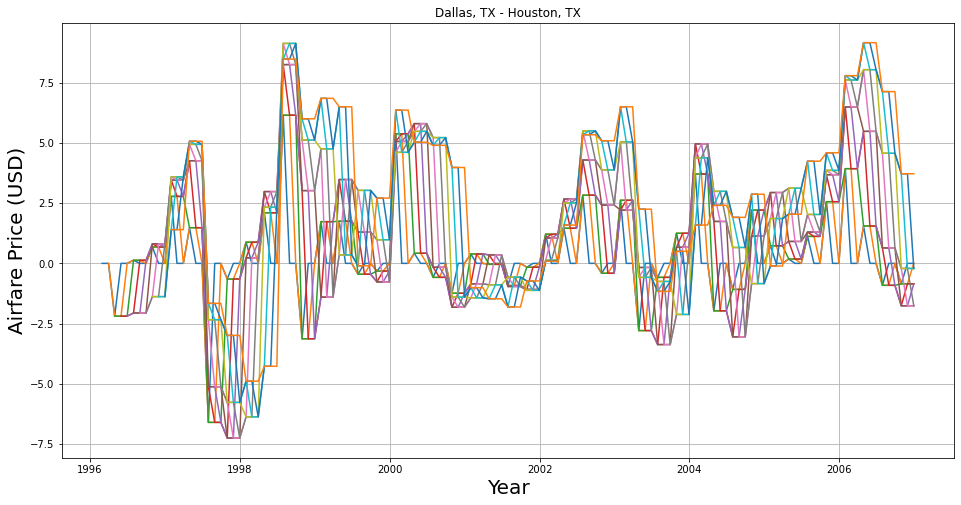

In [1173]:
# diff().diff() is different than .diff(1) and .diff(2)
# this below isn't as import as below where we are making our data stationary

plt.figure(figsize=(16,8))
plt.grid()
plt.xlabel('Year', size=20)
plt.ylabel('Airfare Price (USD)', size=20)
plt.xticks()
plt.title(str(itinerary))
for i in range(1, 13): # 1 month, 2 month....12 months
    plt.plot(route['airfare'].diff(i));

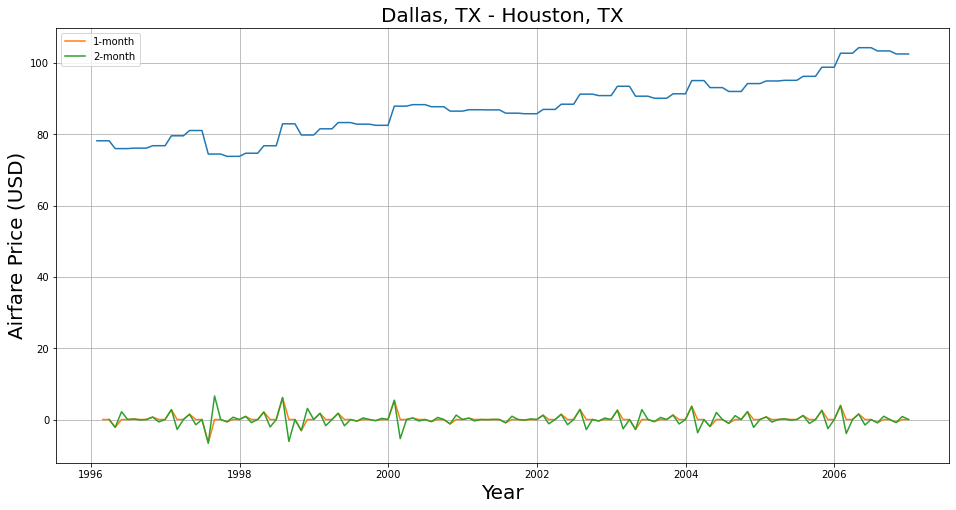

In [1174]:
i = 1
plt.figure(figsize=(16,8))
plt.grid()
plt.xlabel('Year', size=20)
plt.ylabel('Airfare Price (USD)', size=20)
plt.plot(route['airfare'])
plt.plot(route['airfare'].diff(i), label=str(i)+'-month') # select i to see what looks most stationary
plt.plot(route['airfare'].diff(i).diff(i), label=str(i*2)+'-month')
# plt.plot(route['airfare'].diff(i).diff(i).diff(i), label=str(i*3)+'-month')
plt.title(str(itinerary), size=20)
plt.legend();

## .pct_change( )

In [1175]:
route['airfare'].pct_change(1)

year-month
1996-01-31         NaN
1996-02-29    0.000000
1996-03-31    0.000000
1996-04-30   -0.028005
1996-05-31    0.000000
                ...   
2006-08-31    0.000000
2006-09-30    0.000000
2006-10-31   -0.008220
2006-11-30    0.000000
2006-12-31    0.000000
Name: airfare, Length: 132, dtype: float64

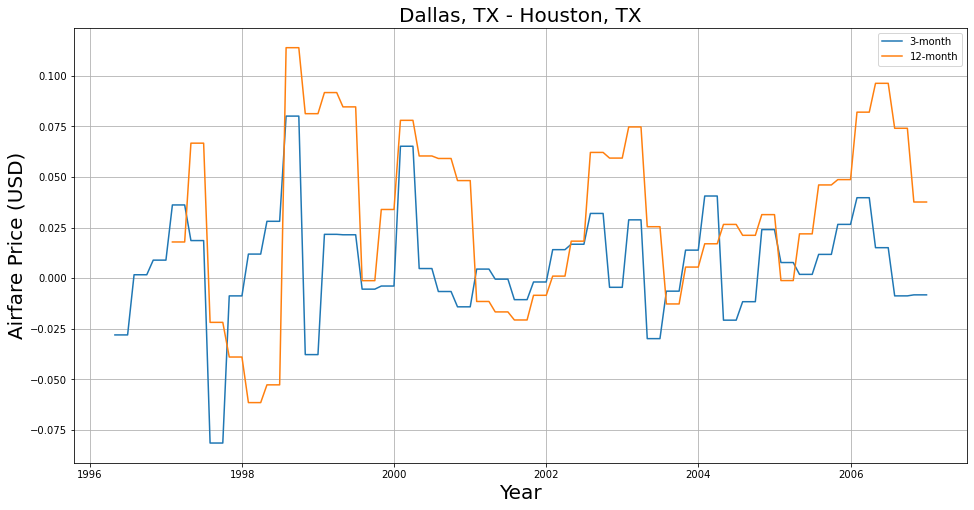

In [1176]:
plt.figure(figsize=(16,8))
plt.grid()
plt.xlabel('Year', size=20)
plt.ylabel('Airfare Price (USD)', size=20)
plt.plot(route['airfare'].pct_change(3), label='3-month')
# plt.plot(route['airfare'].pct_change(6), label='6-month')
# plt.plot(route['airfare'].pct_change(9), label='9-month')
plt.plot(route['airfare'].pct_change(12), label='12-month')
plt.title(str(itinerary), size=20)
plt.legend();

## IDENTIFY PATTERNS

### Decompose Plot

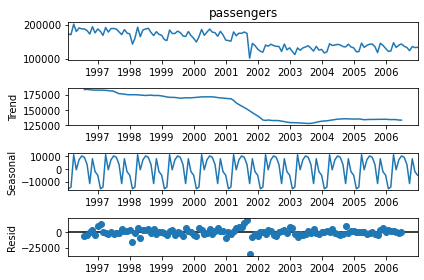

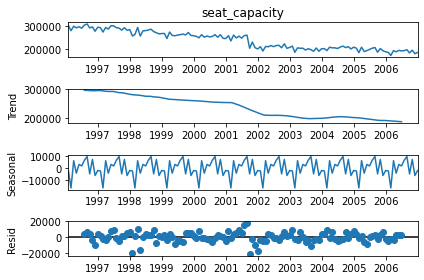

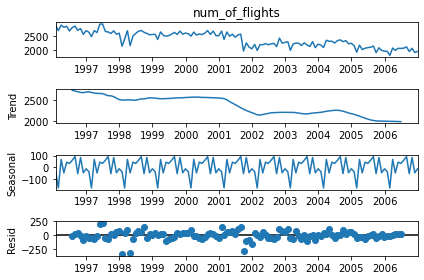

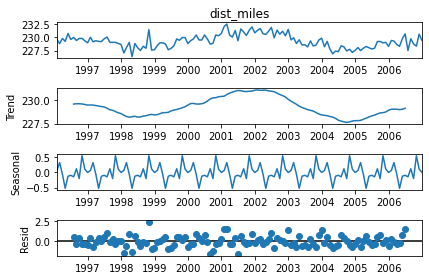

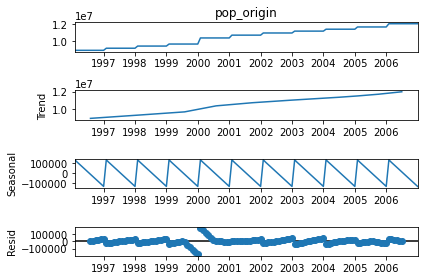

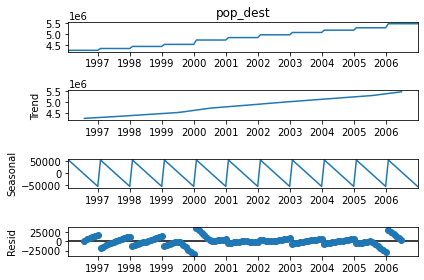

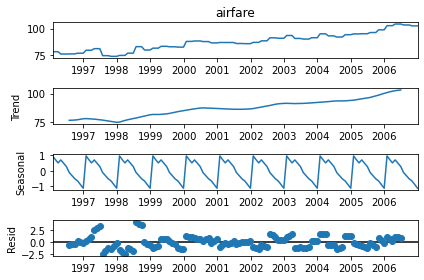

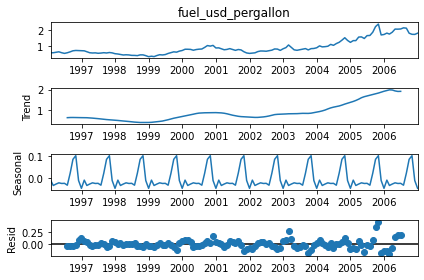

In [1177]:
# Seasonal Decompose Plot Import
from statsmodels.tsa.seasonal import seasonal_decompose

for column in route.columns[1:]:
    seasonal_decompose(route[column]).plot()

# Pre-Processing / Feature Engineering / Feature Selection
- Engineer Features
- Transform Data
    - Ensure Stationarity of Features
- Select Features

### Feature Engineering

In [1178]:
# Create Features for both the ROUTE & UNSEEN ROUTE DATAFRAMES

# PRELIMINARY FEATURES:

    # ROUTE
    route['total_flight_miles'] = route['num_of_flights'] * route['dist_miles']
    route['total_flight_cost'] = route['total_flight_miles'] * route['fuel_usd_pergallon']
    route['flight_demand'] = route['passengers'] / route['seat_capacity']
    route['cost_per_mile'] = route['airfare'] / route['dist_miles']
    route['flight_revenue'] = route['passengers'] * route['airfare']
    route['passengers_per_flight'] = route['passengers'] / route['num_of_flights']

# DATE TIME FEATURES:

    # Time Passed -- 0 at first datetimeindex and increases by 1 each period to end of dataframe
    route['time'] = range(0, route.shape[0])

    # Season Of Year -- Should one hot encode as this is a nominal (not ordinal) feature
    route['season'] = (route.index.month - 1) // 3 + 1




In [1179]:
# Create Features for both the ROUTE & UNSEEN ROUTE DATAFRAMES

# PRELIMINARY FEATURES:

    # UNSEEN ROUTE
    unseen_route['total_flight_miles'] = unseen_route['num_of_flights'] * unseen_route['dist_miles']
    unseen_route['total_flight_cost'] = unseen_route['total_flight_miles'] * unseen_route['fuel_usd_pergallon']
    unseen_route['flight_demand'] = unseen_route['passengers'] / unseen_route['seat_capacity']
    unseen_route['cost_per_mile'] = unseen_route['airfare'] / unseen_route['dist_miles']
    unseen_route['flight_revenue'] = unseen_route['passengers'] * unseen_route['airfare']
    unseen_route['passengers_per_flight'] = unseen_route['passengers'] / unseen_route['num_of_flights']

# DATE TIME FEATURES:

    # Time Passed -- 0 at first datetimeindex and increases by 1 each period to end of dataframe
    unseen_route['time'] = range(0, unseen_route.shape[0])

    # Season Of Year -- Should one hot encode as this is a nominal (not ordinal) feature
    unseen_route['season'] = (unseen_route.index.month - 1) // 3 + 1




/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

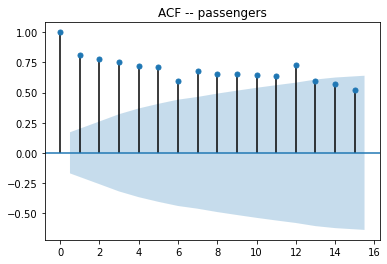

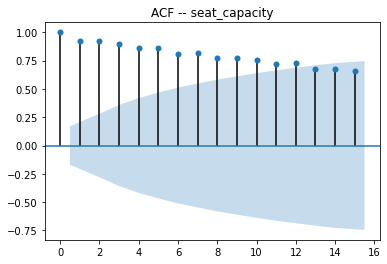

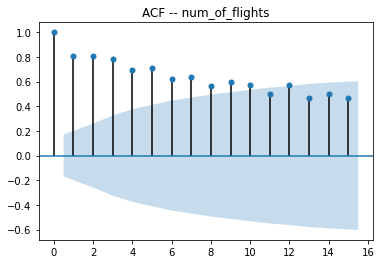

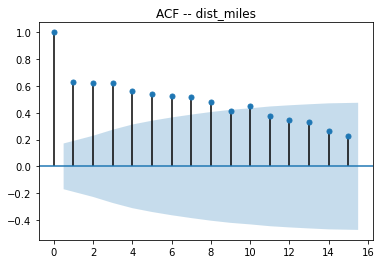

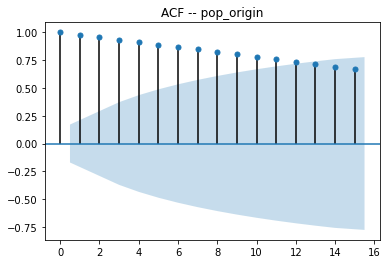

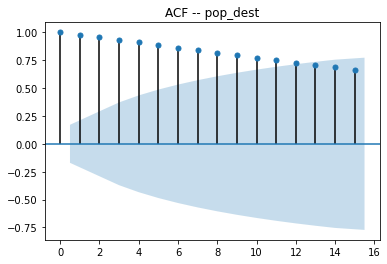

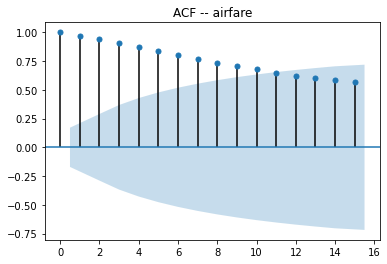

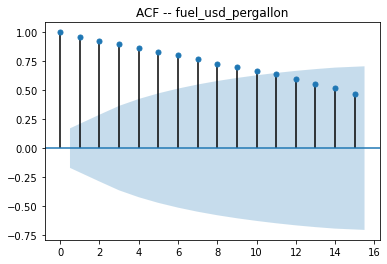

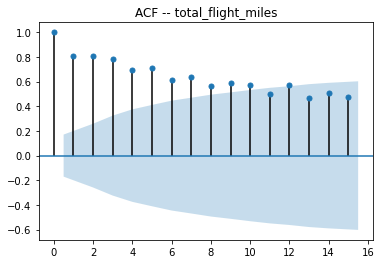

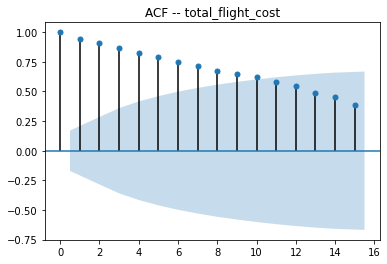

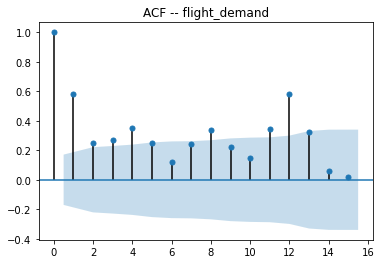

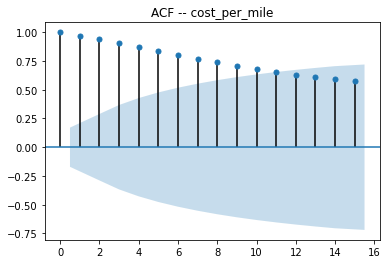

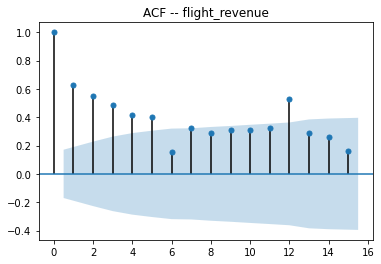

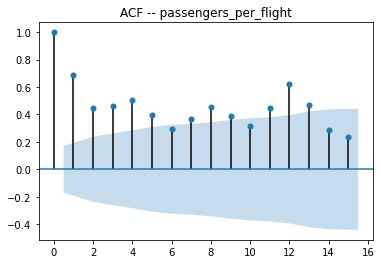

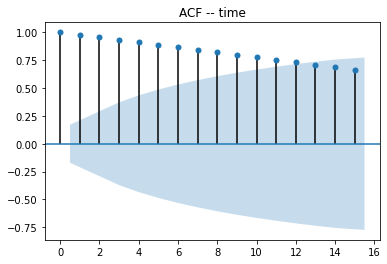

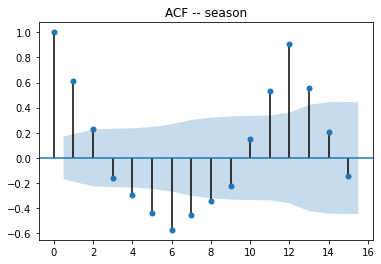

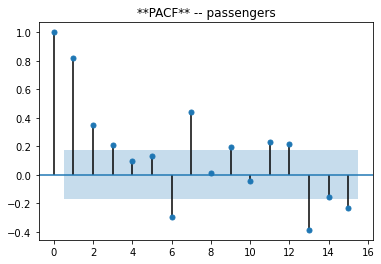

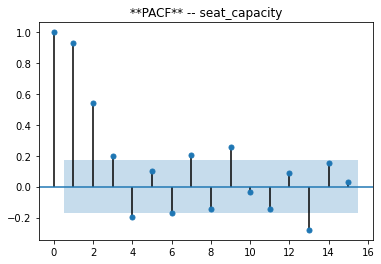

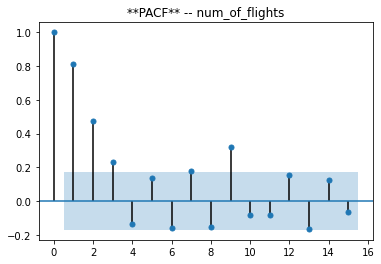

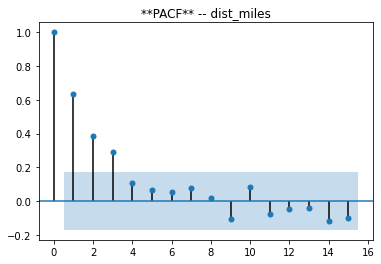

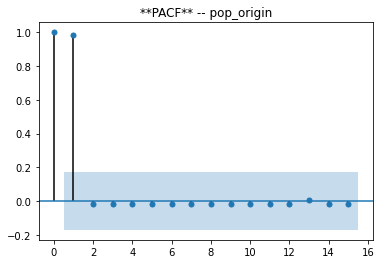

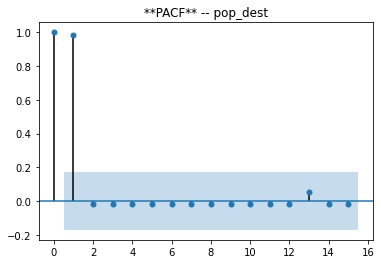

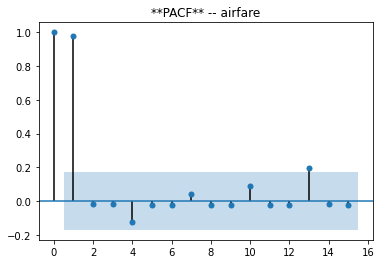

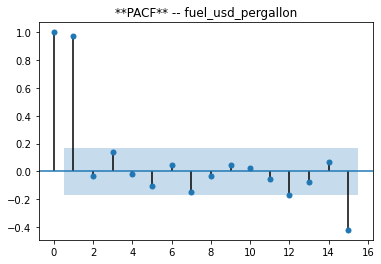

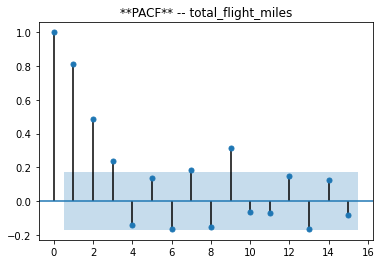

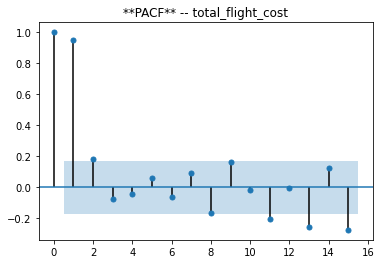

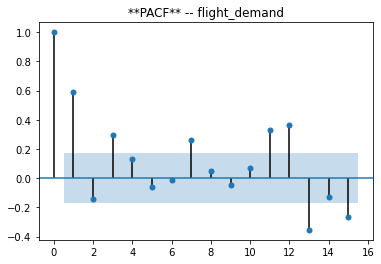

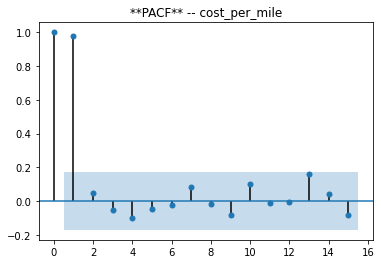

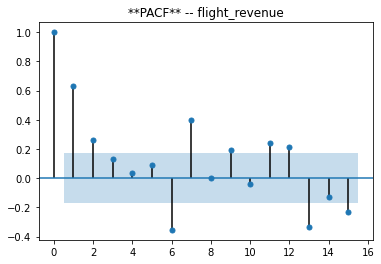

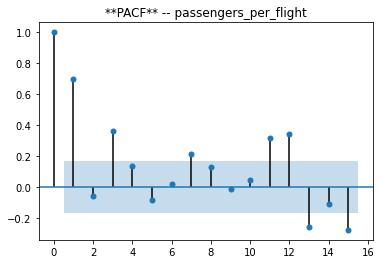

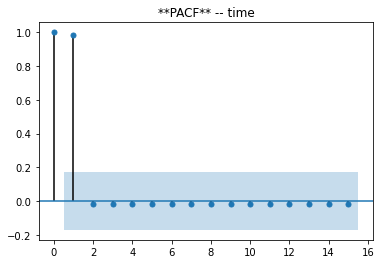

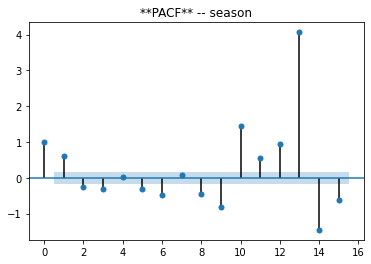

In [1180]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for column in route.columns[1:]:
    plot_acf(route[column], lags=15, alpha=0.05, title='ACF -- ' + str(column))
for column in route.columns[1:]:
    plot_pacf(route[column], lags=15, alpha=0.05, title='**PACF** -- ' + str(column))

In [1181]:
# LAG FEATURES - For Seasonality & Trends
lag_column_list = ['total_flight_cost', 'cost_per_mile', 'cost_per_mile', 'flight_revenue', 'passengers','seat_capacity','num_of_flights',
                   'dist_miles','airfare','fuel_usd_pergallon','total_flight_miles']

for i in lag_column_list:
    route[i + '_lag_1'] = route[i].shift(1)
    unseen_route[i + '_lag_1'] = unseen_route[i].shift(1)
    

    # NEGATIVE LAG
#     for i in route[['passengers_diff_diff', 'seat_capacity_diff_diff', 'num_of_flights_diff_diff', 'dist_miles_diff_diff', 'pop_origin_diff_diff',
#                     'pop_dest_diff_diff', 'airfare_diff_diff', 'fuel_usd_pergallon_diff_diff']].columns:
#         route[str(i) + '_diff_diff_lag_' + str(-1)] = route[i].shift(-1)

# ROLLING MEAN FEATURES

    # rolling(1).mean()
    # rolling(2).mean()
    
# Drop NA columns
route = route.dropna()
unseen_route = unseen_route.dropna()

In [1182]:
# Import & Test for Stationary / Non Stationary Data
from statsmodels.tsa.stattools import adfuller

# https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results -- learn more

def stationary_check(dataseries):

    # When data is STATIONARY, then we can reject the null hypothesis that the data is NOT stationary
    
    critical_value = adfuller(dataseries)[0]
    p_value = adfuller(dataseries)[1]
    num_lags = adfuller(dataseries)[2]
    num_obs = adfuller(dataseries)[3]
    t_values = adfuller(dataseries)[4]
    
    diff = 0
    stationary = False
    
    while stationary == False:
        if diff == 0:    
            if (critical_value > t_values['1%']) and (critical_value > t_values['5%']) and (critical_value > t_values['10%']) and (p_value > 0.05):
                diff += 1
            else:
                stationary = True
        if diff == 1:
            critical_value = adfuller(dataseries.diff().dropna())[0]
            t_values = adfuller(dataseries.diff().dropna())[4]
            p_value = adfuller(dataseries.diff().dropna())[1]
            num_lags = adfuller(dataseries.diff().dropna())[2]
            num_obs = adfuller(dataseries.diff().dropna())[3]
            if (critical_value > t_values['1%']) and (critical_value > t_values['5%']) and (critical_value > t_values['10%']) and (p_value > 0.05):
                diff += 1
            else:
                stationary = True
        if diff == 2:
            critical_value = adfuller(dataseries.diff().diff().dropna())[0]
            t_values = adfuller(dataseries.diff().diff().dropna())[4]
            p_value = adfuller(dataseries.diff().diff().dropna())[1]
            num_lags = adfuller(dataseries.diff().diff().dropna())[2]
            num_obs = adfuller(dataseries.diff().diff().dropna())[3]
            if (critical_value > t_values['1%']) and (critical_value > t_values['5%']) and (critical_value > t_values['10%']) and (p_value > 0.05):
                diff += 1
            else:
                stationary = True
        if diff >= 3:
            print('3 or more diff? Something Is Up!')
            
        break
    print(dataseries.name)
    print('----------------------------------------------------------------')
    print(f'For Stationarity: {diff} {diff * ".diff()"}')
    print('----------------------------------------------------------------')
    print(f'critical_value: {critical_value}')
    print(f'p_value: {p_value}')
    print(f't_values: {t_values}')
    print(f'number of observations: {num_obs}')
    print(f'number of lags: {num_lags}')
    print()

    return diff

In [1183]:
diff_dict = {}
for column in route.columns[1:]:
    diff_dict[column] = stationary_check(route[column])

passengers
----------------------------------------------------------------
For Stationarity: 2 .diff().diff()
----------------------------------------------------------------
critical_value: -9.37134641301258
p_value: 7.363091385713495e-16
t_values: {'1%': -3.4880216384691867, '5%': -2.8867966864160075, '10%': -2.5802408234244947}
number of observations: 116
number of lags: 12

seat_capacity
----------------------------------------------------------------
For Stationarity: 1 .diff()
----------------------------------------------------------------
critical_value: -3.2146705273092766
p_value: 0.019151042164636187
t_values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
number of observations: 118
number of lags: 11

num_of_flights
----------------------------------------------------------------
For Stationarity: 1 .diff()
----------------------------------------------------------------
critical_value: -6.723042560602415
p_value: 3.444325291431098e-09
t

/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:903: RuntimeWarning: divide by zero encountere

time
----------------------------------------------------------------
For Stationarity: 1 .diff()
----------------------------------------------------------------
critical_value: nan
p_value: nan
t_values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
number of observations: 129
number of lags: 0

season
----------------------------------------------------------------
For Stationarity: 0 
----------------------------------------------------------------
critical_value: -792196962454849.8
p_value: 0.0
t_values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
number of observations: 118
number of lags: 12

total_flight_cost_lag_1
----------------------------------------------------------------
For Stationarity: 2 .diff().diff()
----------------------------------------------------------------
critical_value: -7.257209910065656
p_value: 1.718379579456947e-10
t_values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, 

In [1184]:
diff_dict
diff_1 = []
diff_2 = []
for k, v in diff_dict.items():
    if v == 1:
        diff_1.append(k)
    elif v == 2:
        diff_2.append(k)

In [1185]:
diff_dict

{'passengers': 2,
 'seat_capacity': 1,
 'num_of_flights': 1,
 'dist_miles': 1,
 'pop_origin': 2,
 'pop_dest': 2,
 'airfare': 1,
 'fuel_usd_pergallon': 1,
 'total_flight_miles': 1,
 'total_flight_cost': 2,
 'flight_demand': 1,
 'cost_per_mile': 1,
 'flight_revenue': 1,
 'passengers_per_flight': 1,
 'time': 1,
 'season': 0,
 'total_flight_cost_lag_1': 2,
 'cost_per_mile_lag_1': 1,
 'flight_revenue_lag_1': 1,
 'passengers_lag_1': 2,
 'seat_capacity_lag_1': 1,
 'num_of_flights_lag_1': 1,
 'dist_miles_lag_1': 1,
 'airfare_lag_1': 1,
 'fuel_usd_pergallon_lag_1': 1,
 'total_flight_miles_lag_1': 1}

In [1186]:
diff_1

['seat_capacity',
 'num_of_flights',
 'dist_miles',
 'airfare',
 'fuel_usd_pergallon',
 'total_flight_miles',
 'flight_demand',
 'cost_per_mile',
 'flight_revenue',
 'passengers_per_flight',
 'time',
 'cost_per_mile_lag_1',
 'flight_revenue_lag_1',
 'seat_capacity_lag_1',
 'num_of_flights_lag_1',
 'dist_miles_lag_1',
 'airfare_lag_1',
 'fuel_usd_pergallon_lag_1',
 'total_flight_miles_lag_1']

In [1187]:
# Create Stationary (differenced) Columns

# train route dataset
for column in diff_1:
    route[column + '_diff_1'] = route[column].diff()
for column in diff_2:
    route[column + '_diff_2'] = route[column].diff().diff()
    
# test route dataset
for column in diff_1:
    unseen_route[column + '_diff_1'] = unseen_route[column].diff()
for column in diff_2:
    unseen_route[column + '_diff_2'] = unseen_route[column].diff().diff()

In [1188]:
route.columns

Index(['route', 'passengers', 'seat_capacity', 'num_of_flights', 'dist_miles',
       'pop_origin', 'pop_dest', 'airfare', 'fuel_usd_pergallon',
       'total_flight_miles', 'total_flight_cost', 'flight_demand',
       'cost_per_mile', 'flight_revenue', 'passengers_per_flight', 'time',
       'season', 'total_flight_cost_lag_1', 'cost_per_mile_lag_1',
       'flight_revenue_lag_1', 'passengers_lag_1', 'seat_capacity_lag_1',
       'num_of_flights_lag_1', 'dist_miles_lag_1', 'airfare_lag_1',
       'fuel_usd_pergallon_lag_1', 'total_flight_miles_lag_1',
       'seat_capacity_diff_1', 'num_of_flights_diff_1', 'dist_miles_diff_1',
       'airfare_diff_1', 'fuel_usd_pergallon_diff_1',
       'total_flight_miles_diff_1', 'flight_demand_diff_1',
       'cost_per_mile_diff_1', 'flight_revenue_diff_1',
       'passengers_per_flight_diff_1', 'time_diff_1',
       'cost_per_mile_lag_1_diff_1', 'flight_revenue_lag_1_diff_1',
       'seat_capacity_lag_1_diff_1', 'num_of_flights_lag_1_diff_1',
    

#### Polynomial Features?

In [1189]:
# from sklearn.preprocessing import PolynomialFeatures

# poly = PolynomialFeatures(include_bias=False, degree=3)
# X_poly = poly.fit_transform(route.drop(columns=['FIRST_DIGIT', 'airfare', 'route']))

# # View X_poly in a DataFrame
# pd.DataFrame(X_poly, columns=poly.get_feature_names(route.drop(columns=['FIRST_DIGIT', 'airfare', 'route']).columns)).head()

### TRAIN / TEST / SPLIT

In [1190]:
sorted(route.columns)

['airfare',
 'airfare_diff_1',
 'airfare_lag_1',
 'airfare_lag_1_diff_1',
 'cost_per_mile',
 'cost_per_mile_diff_1',
 'cost_per_mile_lag_1',
 'cost_per_mile_lag_1_diff_1',
 'dist_miles',
 'dist_miles_diff_1',
 'dist_miles_lag_1',
 'dist_miles_lag_1_diff_1',
 'flight_demand',
 'flight_demand_diff_1',
 'flight_revenue',
 'flight_revenue_diff_1',
 'flight_revenue_lag_1',
 'flight_revenue_lag_1_diff_1',
 'fuel_usd_pergallon',
 'fuel_usd_pergallon_diff_1',
 'fuel_usd_pergallon_lag_1',
 'fuel_usd_pergallon_lag_1_diff_1',
 'num_of_flights',
 'num_of_flights_diff_1',
 'num_of_flights_lag_1',
 'num_of_flights_lag_1_diff_1',
 'passengers',
 'passengers_diff_2',
 'passengers_lag_1',
 'passengers_lag_1_diff_2',
 'passengers_per_flight',
 'passengers_per_flight_diff_1',
 'pop_dest',
 'pop_dest_diff_2',
 'pop_origin',
 'pop_origin_diff_2',
 'route',
 'season',
 'seat_capacity',
 'seat_capacity_diff_1',
 'seat_capacity_lag_1',
 'seat_capacity_lag_1_diff_1',
 'time',
 'time_diff_1',
 'total_flight_cos

In [1191]:
# Import train/test split
from sklearn.model_selection import train_test_split

keep_columns = [
#  'airfare',
#  'airfare_diff_1',
#  'airfare_lag_1',
 'airfare_lag_1_diff_1',
#  'cost_per_mile',
#  'cost_per_mile_diff_1',
#  'cost_per_mile_lag_1',
 'cost_per_mile_lag_1_diff_1',
#  'dist_miles',
#  'dist_miles_diff_1',
#  'dist_miles_lag_1',
 'dist_miles_lag_1_diff_1',
#  'flight_demand',
 'flight_demand_diff_1',
#  'flight_revenue',
#  'flight_revenue_diff_1',
#  'flight_revenue_lag_1',
 'flight_revenue_lag_1_diff_1',
#  'fuel_usd_pergallon',
#  'fuel_usd_pergallon_diff_1',
#  'fuel_usd_pergallon_lag_1',
 'fuel_usd_pergallon_lag_1_diff_1',
#  'num_of_flights',
#  'num_of_flights_diff_1',
#  'num_of_flights_lag_1',
 'num_of_flights_lag_1_diff_1',
#  'passengers',
#  'passengers_diff_2',
#  'passengers_lag_1',
 'passengers_lag_1_diff_2',
# 'passengers_per_flight',
'passengers_per_flight_diff_1',
#  'pop_dest',
#  'pop_dest_diff_2',
#  'pop_origin',
#  'pop_origin_diff_2',
#  'route',
#  'season',
#  'seat_capacity',
#  'seat_capacity_diff_1',
#  'seat_capacity_lag_1',
 'seat_capacity_lag_1_diff_1',
 'time',
#  'time_diff_1',
#  'total_flight_cost',
#  'total_flight_cost_diff_2',
#  'total_flight_cost_lag_1',
 'total_flight_cost_lag_1_diff_2',
#  'total_flight_miles',
#  'total_flight_miles_diff_1',
#  'total_flight_miles_lag_1',
 'total_flight_miles_lag_1_diff_1'
]

# Set X & y values
X = route[keep_columns]

y = route['airfare']

# after looking at coefficients, resaving X and running again
# X = route[['time', 'fuel_usd_pergallon_lag_1_diff_1', 'total_flight_cost_lag_1_diff_2']]

In [1192]:
# Generate train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)

In [1193]:
# Check shape to confirm we did this properly.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(91, 13)
(40, 13)
(91,)
(40,)


# MODELING

https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/


<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/02/flowchart.png" style="float: left; margin: 80px; height: 220px">

# Model # 1

## **Linear Model**

In [1198]:
# Import statsmodels.
import statsmodels.api as sm

# Since we are using STATSMODELS we must create the intercepts on our train & test data
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# STATSMODELS won't be able to handle missing values so we must remove them
X_train.dropna(inplace=True)

# We must now subset y to match the index from X
y_train = y_train[X_train.index]

# Instantiate & pass in data at same time, then fit model -- reminder:  this is done differently (backwards) with STATSMODEL than scikitlearn
# FOR REFERENCE -- https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
lm = sm.OLS(y_train, X_train)
lm_results = lm.fit()

# Display our summary!
print()
print(itinerary)
print()
lm_results.summary()


Dallas, TX - Houston, TX



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                airfare   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     35.49
Date:                Thu, 01 Oct 2020   Prob (F-statistic):           1.01e-26
Time:                        19:29:10   Log-Likelihood:                -192.01
No. Observations:                  89   AIC:                             412.0
Df Residuals:                      75   BIC:                             446.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              74.2687      0.507    146.610      0.000      73.260      75.278
airfare_lag_1_diff_1                5.8212     12.066      0.482      0.631     -18.215      29.857
cost_per_mile_lag_1_diff_1      -1237.1935   2761.750     -0.448      0.655   -6738.882    4264.495
dist_miles_lag_1_diff_1            -1.0859      4.981     -0.218      0.828     -11.008       8.836
flight_demand_diff_1               23.0498     18.866      1.222      0.226     -14.534      60.634
flight_revenue_lag_1_diff_1     -2.086e-08   4.44e-07     -0.047      0.963   -9.06e-07    8.64e-07
fuel_usd_pergallon_lag_1_diff_1    11.7176      5.165      2.269      0.026       1.429      22.006
num_of_flights_lag_1_diff_1         0.0736      0.196      0.375      0.709      -0.318       0.465
passengers_lag_1_diff_2         -6.378e-06   2.01e-05     -0.317      0.752   -4.64e-05    3.36e-05
passengers_per_flight_diff_1       -0.2447      0.179     -1.364      0.177      -0.602       0.113
seat_capacity_lag_1_diff_1       4.745e-05   6.91e-05      0.687      0.494   -9.02e-05       0.000
time                                0.1979      0.010     20.693      0.000       0.179       0.217
total_flight_cost_lag_1_diff_2  -1.421e-05   8.16e-06     -1.742      0.086   -3.05e-05    2.04e-06
total_flight_miles_lag_1_diff_1    -0.0003      0.001     -0.358      0.721      -0.002       0.001
==============================================================================
Omnibus:                        0.879   Durbin-Watson:                   0.648
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.911
Skew:                          -0.228   Prob(JB):                        0.634
Kurtosis:                       2.805   Cond. No.                     1.50e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Next Steps:
- Look at coefficients
- Check out p-values
- select features
- **interpret results:**
    - R2 & Adjusted R2
        - R2 is the % influence on the target variable the current features have
        - R2 Adjusted punishes R2 score when needless features are added/included
    - F-Statistic (F Test)
        - Null hypothesis: the intercept only model (with no features) and our model with intercept and features is equal
        - Alternate hypothesis: the intercept only model is worse than our model with intercept and features
        - Given the F-Statistic is large and the P-Value (Prob) is close to zero we can reject the null hypthosis
        - If F-Statistic over 1 and p-value less than 0.05 it shows a good relationhsip between target and feature variables and there is evidence of a linear relationship between our features and target variable 
    - T-Statistic (T Test)
        - this is an individual feature test which shows relationship between target and predictive variable independently.  Relationship between Target Variable and every predictive variable independently without taking into account all the features at once - one feature at a time
        - null hypothesis is that feature 1 = 0 (false), alternate is feature != 0 (true)
        - higher the t-value the greater chance you reject the null hypothesis
        - Lower 'P>[t]' - below 0.05 then feature is relevant and we should keep it meaning we reject null hypothesis
    - Skew
        - when skew = 0 it means normal distribution -- null hypothesis is that data is normally distributed or skew = 0
    - Kurtosis 
        - Kurtosis of the normal distribution is 3.0
        - While measuring the departure from normality, Kurtosis is sometimes expressed as excess Kurtosis which is the balance amount of Kurtosis after subtracting 3.0  
        
    [**Normality tests based on Skewness and Kurtosis**](https://towardsdatascience.com/testing-for-normality-using-skewness-and-kurtosis-afd61be860) 
        - While Skewness and Kurtosis quantify the amount of departure from normality, one would want to know if the departure is statistically significant. The following two tests let us do just that:
            - The Omnibus K-squared test
            - The Jarque–Bera test
        - In both tests, we start with the following hypotheses:
            - Null hypothesis (H_0): The data is normally distributed.
            - Alternate hypothesis (H_1): The data is not normally distributed, in other words, the departure from normality, as measured by the test statistic, is statistically significant.

In [1199]:
lm_results.pvalues.sort_values()[0:2]

const    5.748865e-94
time     9.930689e-33
dtype: float64

In [1200]:
lm_results.params.sort_values()[0:2]

cost_per_mile_lag_1_diff_1   -1237.193487
dist_miles_lag_1_diff_1         -1.085886
dtype: float64

In [1245]:
# Generate predicted test values.

# Drop NAs & Match indexes
X_test.dropna(inplace=True)

# Generate predictions
ols_pred = lm_results.predict(X_test)

# Import R2 score and MSE.
from sklearn.metrics import r2_score, mean_squared_error

# Baseline Series
y_test_baseline = [y_test.mean()] * len(y_test) # ASK NOAH ABOUT this should baseline be based on entire target variable dataseries, y_train, or y_test

# scoring
print('-------------------------')
print('Train Analytics')
print('-------------------------')
print(f'     TRAIN R2: {r2_score(y_train, lm_results.predict(X_train))}')
print(f'   TRAIN RMSE: {mean_squared_error(y_train, lm_results.predict(X_train), squared=False)}')
print(f'    TRAIN MSE: {mean_squared_error(y_train, lm_results.predict(X_train))}')
print('-------------------------')
print('Test Analytics')
print('-------------------------')
print(f'      TEST R2: {r2_score(y_test, ols_pred)}')
print(f'    TEST RMSE: {mean_squared_error(y_test, ols_pred, squared=False)}')
print(f'     TEST MSE: {mean_squared_error(y_test, ols_pred)}')
print('-------------------------')
print('Baseline Analytics')
print('-------------------------')
print(f'  Baseline R2: {r2_score(y_test, y_test_baseline)}') # SOMETHING IS VERY FISHY -- is this because of adding a constant!?
print(f'Baseline RMSE: {mean_squared_error(y_test, y_test_baseline, squared=False)}')
print(f' Baseline MSE: {mean_squared_error(y_test, y_test_baseline)}')
print()

-------------------------
Train Analytics
-------------------------
     TRAIN R2: 0.8601708458087118
   TRAIN RMSE: 2.0926561865472477
    TRAIN MSE: 4.379209915094469
-------------------------
Test Analytics
-------------------------
      TEST R2: 0.4592547066395771
    TEST RMSE: 3.2990775640550516
     TEST MSE: 10.883912773651412
-------------------------
Baseline Analytics
-------------------------
  Baseline R2: -2.220446049250313e-16
Baseline RMSE: 4.486380995579843
 Baseline MSE: 20.127614437499986



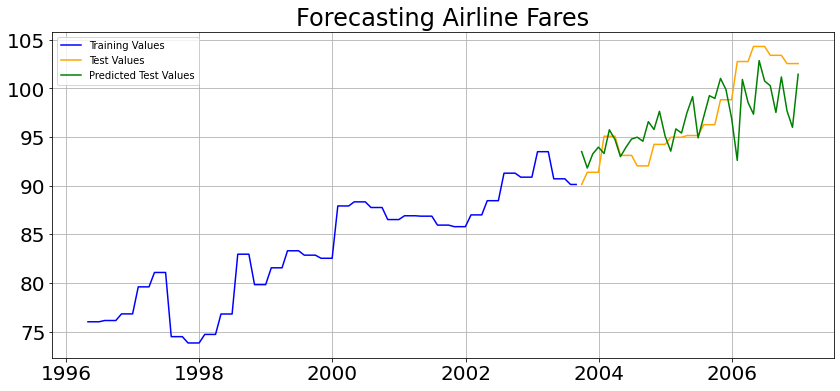

In [1251]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(14, 6))
plt.grid()

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue', label='Training Values')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange', label='Test Values')

# Plot predicted test values.
plt.plot(ols_pred, color = 'green', label='Predicted Test Values')

# Set label.
plt.title(label = 'Forecasting Airline Fares', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);

# add legend
plt.legend();

# TEST MODEL 1 on UNSEEN DATA

In [1247]:
# the dataframe unseen data was created earlier in the notebook to match the route dataframe.  keep columns variable ensures matched variables for modeling
X_unseen = unseen_route[keep_columns]

# Add X Constant
X_unseen = sm.add_constant(X_unseen)

# Make Predictions -- In this case we are predicting airfare price
unseen_pred = lm_results.predict(X_unseen)

# save predictions to unseen route df
unseen_route['airfare_predictions'] = unseen_pred

# dropna values for scoring
unseen_route = unseen_route.dropna()

# score
print('-------------------------------------------')
print('Analytics for Predictions on unseen Data')
print('-------------------------------------------')
print(f'      PRED R2: {r2_score(unseen_route.airfare, unseen_route.airfare_predictions)}')
print(f'    PRED RMSE: {mean_squared_error(unseen_route.airfare, unseen_route.airfare_predictions, squared=False)}')
print(f'     PRED MSE: {mean_squared_error(unseen_route.airfare, unseen_route.airfare_predictions, squared=True)}')

-------------------------------------------
Analytics for Predictions on unseen Data
-------------------------------------------
      PRED R2: -27.171844669239903
    PRED RMSE: 37.968596127821165
     PRED MSE: 1441.6142919175961


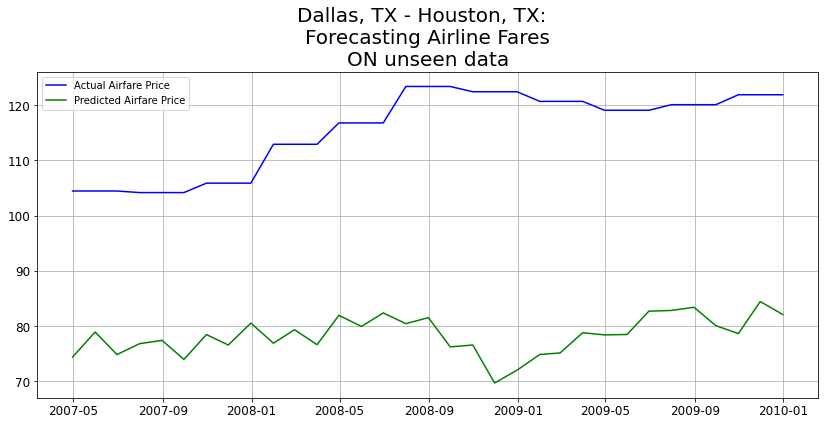

In [1118]:
# Let's plot our predictions! 

# Set figure size.
plt.figure(figsize=(14, 6))
plt.grid()

# Plot actual data.
plt.plot(unseen_route['airfare'], color = 'blue', label='Actual Airfare Price')

# Plot predicted test values.
# plt.plot(lm_results.predict(X_air), color = 'green', label='Predicted Airfare Price')
plt.plot(unseen_route['airfare_predictions'], color = 'green', label='Predicted Airfare Price')

# Set label.
plt.title(label = str(itinerary) + ':  ' + '\nForecasting Airline Fares\nON unseen data', fontsize=20)

# Resize tick marks.
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

# add legend
plt.legend();

# MODEL 2 - SARIMAX & variations

In [1119]:
# Create train-test split.
y_train, y_test = train_test_split(route['airfare'],
                                   test_size = 0.1,
                                   shuffle = False
                                  )

In [1427]:
# Import ARIMA model.
from statsmodels.tsa.arima_model import ARIMA

## Manual GridSearch

Our strategy is this:
- Let's start AIC at some really, really big number and call it `best_aic`.
- Create variables `best_p` and `best_q` to store our best values of $p$ and $q$.
- Create a nested `for` loop to iterate over our possible values of $p$ and $q$.
    - At every combination of $p$ and $q$, fit an ARIMA model.
    - If the ARIMA model has a better (lower) AIC than `best_aic`, then let's overwrite `best_aic`, `best_p`, and `best_q` with the values of AIC, $p$, and $q$ that our better model is using!
    - If the ARIMA model has a worse (higher) AIC than `best_aic`, do nothing.
- At the end of the `for` loop, tell us which values of $p$ and $q$ give us the best model (lowest AIC).

<details><summary>What should our main concerns be about a manual GridSearch process?</summary>

- The amount of time it takes to fit our models!
- Cross-validation is also more complicated with time series data; you can check out more [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [here](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/).
</details>

<details><summary>What is the purpose of try and except statements?</summary>

- If our code encounters an error, then it will automatically stop. Sometimes this is good (so we can debug) but sometimes this isn't desirable!
- `try` and `except` statements allow us to "try" to do something and, if there's an error, we can just `pass` it so that our code doesn't stop running.
- This isn't always a good thing... errors are usually telling us that something is wrong. But we're going to hack our answer here so that we can check all values of $p$ and $q$ and just not run the model if some values of $p$ and $q$ are invalid.
</details>

In [1428]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        
        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},1,{q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
                          order = (p,1,q), # values of p, d, q
                          freq = 'M', exog=None)
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,1,0)
The AIC for ARIMA(0,1,0) is: 780.7921576041589
Attempting to fit ARIMA(0,1,1)
The AIC for ARIMA(0,1,1) is: 782.7919301820632
Attempting to fit ARIMA(0,1,2)
The AIC for ARIMA(0,1,2) is: 784.7916754513632
Attempting to fit ARIMA(0,1,3)
The AIC for ARIMA(0,1,3) is: 786.7084237911592
Attempting to fit ARIMA(0,1,4)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


The AIC for ARIMA(0,1,4) is: 788.7081628567458
Attempting to fit ARIMA(1,1,0)
The AIC for ARIMA(1,1,0) is: 782.7919308375602
Attempting to fit ARIMA(1,1,1)
The AIC for ARIMA(1,1,1) is: 779.3753440862133
Attempting to fit ARIMA(1,1,2)
The AIC for ARIMA(1,1,2) is: 781.0117765306801
Attempting to fit ARIMA(1,1,3)
The AIC for ARIMA(1,1,3) is: 782.607283322672
Attempting to fit ARIMA(1,1,4)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


The AIC for ARIMA(1,1,4) is: 784.5038159299434
Attempting to fit ARIMA(2,1,0)
The AIC for ARIMA(2,1,0) is: 784.7917021168603
Attempting to fit ARIMA(2,1,1)
The AIC for ARIMA(2,1,1) is: 780.9587563469005
Attempting to fit ARIMA(2,1,2)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(2,1,2) is: 782.7971744623147
Attempting to fit ARIMA(2,1,3)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(2,1,3) is: 784.1243494041914
Attempting to fit ARIMA(2,1,4)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(2,1,4) is: 785.9600985415109
Attempting to fit ARIMA(3,1,0)
The AIC for ARIMA(3,1,0) is: 786.7075039247095
Attempting to fit ARIMA(3,1,1)
The AIC for ARIMA(3,1,1) is: 782.4725465200568
Attempting to fit ARIMA(3,1,2)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:410: RuntimeWarning: invalid value encountered in subtract
  dx = ((x0 + h) - x0)
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:496: RuntimeWarning: invalid value encountered in double_scalars
  dx = x[i] - x0[i]  # Recompute dx as exactly representable number.


Attempting to fit ARIMA(3,1,3)
The AIC for ARIMA(3,1,3) is: 779.6525419108261
Attempting to fit ARIMA(3,1,4)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(3,1,4) is: 780.8261055853798
Attempting to fit ARIMA(4,1,0)
The AIC for ARIMA(4,1,0) is: 788.7072632653221
Attempting to fit ARIMA(4,1,1)
The AIC for ARIMA(4,1,1) is: 784.2645737540647
Attempting to fit ARIMA(4,1,2)
The AIC for ARIMA(4,1,2) is: 785.8408897054642
Attempting to fit ARIMA(4,1,3)


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The AIC for ARIMA(4,1,3) is: 780.9064601394033
Attempting to fit ARIMA(4,1,4)


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(1,1,1).
This model has an AIC of 779.3753440862133.


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:726: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equal
  sign_x0 = (x0 >= 0).astype(float) * 2 - 1


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


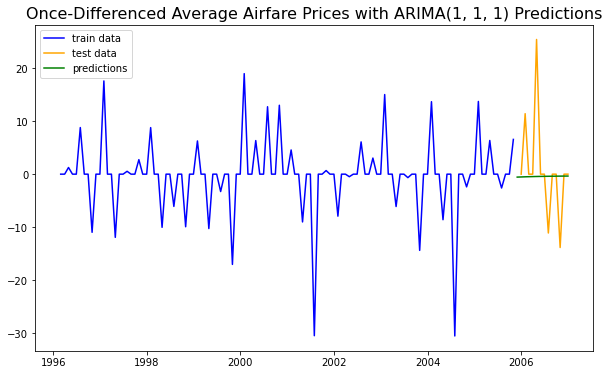

In [1429]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable
              order = (1,1,1))

# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                      start = y_test.index[0],
                      end = y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue', label='train data')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange', label='test data')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green', label='predictions')

plt.title(label = 'Once-Differenced Average Airfare Prices with ARIMA(1, 1, 1) Predictions', fontsize=16)
plt.legend()
plt.show();

# MODEL 3 - VAR Time Series Model

https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

In [780]:
# Import VAR
# from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen # this is to check for stationarity with Multivariate (DickeyFuller for Univariate)

In [781]:
route.columns

Index(['route', 'passengers', 'seat_capacity', 'num_of_flights', 'dist_miles',
       'pop_origin', 'pop_dest', 'airfare', 'fuel_usd_pergallon',
       'total_flight_miles', 'total_flight_cost', 'flight_demand',
       'cost_per_mile', 'flight_revenue', 'time', 'season',
       'total_flight_cost_lag_1', 'cost_per_mile_lag_1',
       'flight_revenue_lag_1', 'passengers_lag_1', 'seat_capacity_lag_1',
       'num_of_flights_lag_1', 'dist_miles_lag_1', 'airfare_lag_1',
       'fuel_usd_pergallon_lag_1', 'total_flight_miles_lag_1',
       'seat_capacity_diff_1', 'num_of_flights_diff_1', 'dist_miles_diff_1',
       'airfare_diff_1', 'fuel_usd_pergallon_diff_1',
       'total_flight_miles_diff_1', 'flight_demand_diff_1',
       'cost_per_mile_diff_1', 'flight_revenue_diff_1', 'time_diff_1',
       'cost_per_mile_lag_1_diff_1', 'flight_revenue_lag_1_diff_1',
       'seat_capacity_lag_1_diff_1', 'num_of_flights_lag_1_diff_1',
       'dist_miles_lag_1_diff_1', 'airfare_lag_1_diff_1',
       'fu

In [782]:
var = route.iloc[:, 1:13].copy()
var = route[['passengers', 'total_flight_miles', 'flight_demand', 'airfare', 'cost_per_mile']].copy()

In [783]:
var.columns

Index(['passengers', 'total_flight_miles', 'flight_demand', 'airfare',
       'cost_per_mile'],
      dtype='object')

In [784]:
# https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.vecm.JohansenTestResult.html
jtr = coint_johansen(endog=var, det_order=-1, k_ar_diff=1) #.eig
jtr

In [785]:
jtr.cvm # Critical values (90%, 95%, 99%) of maximum eigenvalue statistic.
jtr.cvt # Critical values (90%, 95%, 99%) of trace statistic
jtr.eig # Eigenvalues of VECM coefficient matrix

array([0.38530816, 0.0808706 , 0.0615473 , 0.04467118, 0.01374817])

In [786]:
for index, value in enumerate(jtr.eig):
    print(index, value)

0 0.38530815867461843
1 0.08087060491677137
2 0.061547300753562996
3 0.04467118034883871
4 0.013748173656539792


In [787]:
var_train = var[:int(0.8 * (len(var)))]
var_test = var[:int(0.2 * (len(var)))]

In [788]:
var_train.shape
var_test.shape

(26, 5)

In [789]:
model = VAR(endog=var_train)
model_fit = model.fit()

/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [790]:
# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(var_test))

In [793]:
pred = pd.DataFrame(index=range(0, len(prediction)),columns=var_test.columns)
for j in range(0, len(var.columns)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

In [794]:
pred.head()

,passengers,total_flight_miles,flight_demand,airfare,cost_per_mile
0,137257,524525,0.660468,91.8677,0.402741
1,137663,524562,0.660642,91.7895,0.401703
2,137504,523746,0.659263,91.7529,0.401084
3,137294,522919,0.657945,91.7391,0.4007
4,137135,522269,0.656959,91.7394,0.400468


In [795]:
# for i in pred.columns:
#     pred[i] = pred[i].astype(float)
# pred.head()

In [796]:
pred.shape
var_test.shape

(26, 5)

In [797]:
from sklearn.metrics import mean_squared_error

#check rmse
for i in var_test.columns:
    print('rmse value for', i, 'is : ', mean_squared_error(pred[i], var_test[i])**0.5)

rmse value for passengers is :  44856.35785729037
rmse value for total_flight_miles is :  98075.9012477295
rmse value for flight_demand is :  0.04416376156723515
rmse value for airfare is :  15.382413479971621
rmse value for cost_per_mile is :  0.0670379694718313


In [743]:
model = VAR(endog=var)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
for i in yhat[0]:
    print(i)

# for i in var_test.columns:
#     print('rmse value for', i, 'is : ', mean_squared_error(pred[i], var_test[i])**0.5)

129916.0952025298
181763.2925770511
1929.1452938258153
228.81394811109197
11992961.038668754
5485034.380043926
102.7028229134198
1.842244010159932
441237.0249277372
821811.38348692
0.7136630318505492
0.4487630568428371


/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [1431]:
route.head(1)

,route,passengers,seat_capacity,num_of_flights,dist_miles,pop_origin,pop_dest,airfare,fuel_usd_pergallon,FIRST_DIGIT,...,airfare_trend_lag_2,airfare_trend_lag_3,airfare_trend_lag_4,airfare_trend_lag_5,airfare_trend_lag_6,airfare_trend_lag_7,airfare_trend_lag_8,airfare_seasonal_lag_6,airfare_seasonal_lag_12,time
year-month,,,,,,,,,,,,,,,,,,,,,
1996-01-31,"Atlanta, GA - Washington, DC",61199,95680,658,539.0,3652439,8857302,167.42,0.55,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [1432]:
route.columns

Index(['route', 'passengers', 'seat_capacity', 'num_of_flights', 'dist_miles',
       'pop_origin', 'pop_dest', 'airfare', 'fuel_usd_pergallon',
       'FIRST_DIGIT', 'airfare_trend_lag_1', 'airfare_trend_lag_2',
       'airfare_trend_lag_3', 'airfare_trend_lag_4', 'airfare_trend_lag_5',
       'airfare_trend_lag_6', 'airfare_trend_lag_7', 'airfare_trend_lag_8',
       'airfare_seasonal_lag_6', 'airfare_seasonal_lag_12', 'time'],
      dtype='object')

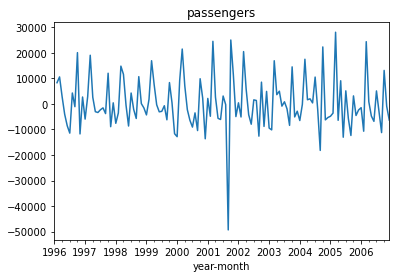

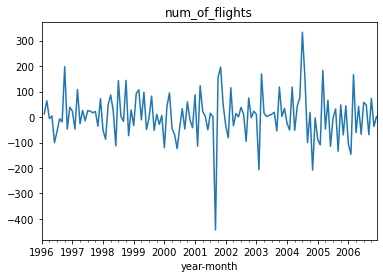

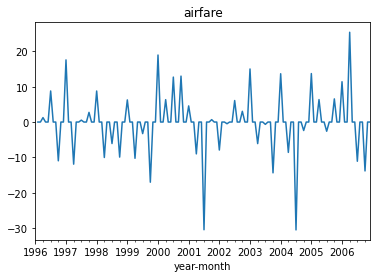

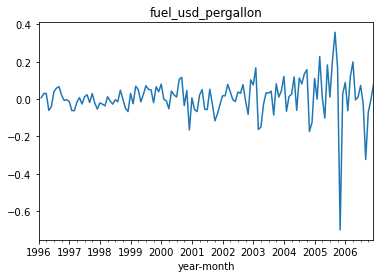

In [1433]:
check_for_stationarity = route[['passengers', 'num_of_flights', 'airfare', 'fuel_usd_pergallon']].copy()
for i in check_for_stationarity:
    plt.figure()
    plt.title(i)
    route[i].diff(1).plot()
    check_for_stationarity[i + '_first_diff'] = route[i].diff(1)

In [1434]:
check_for_stationarity.columns

Index(['passengers', 'num_of_flights', 'airfare', 'fuel_usd_pergallon',
       'passengers_first_diff', 'num_of_flights_first_diff',
       'airfare_first_diff', 'fuel_usd_pergallon_first_diff'],
      dtype='object')

In [1435]:
# Subset our data.
check_for_stationarity = check_for_stationarity[['passengers_first_diff', 'num_of_flights_first_diff',
       'airfare_first_diff', 'fuel_usd_pergallon_first_diff']]

# Let's get rid of rows containing missing values.
check_for_stationarity.dropna(inplace = True)

check_for_stationarity.head()

,passengers_first_diff,num_of_flights_first_diff,airfare_first_diff,fuel_usd_pergallon_first_diff
year-month,,,,
1996-02-29,8312.0,13.0,0.00,0.007
1996-03-31,10587.0,64.0,0.00,0.029
1996-04-30,2844.0,-6.0,1.26,0.031
1996-05-31,-4038.0,4.0,0.00,-0.060
1996-06-30,-8544.0,-100.0,0.00,-0.041


In [1436]:
train, test = train_test_split(check_for_stationarity,
                               test_size = 0.25,
                              shuffle=False)  # shuffle has to be set to false so it is ordered by date

In [1437]:
# Instantiate a VAR model. Remember that we pass
# our data in during instantiation in statsmodels!
model = VAR(train) # freqency inferred is Q-DEC

/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [1438]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(maxlags=15, # what is the largest possible value of p?
                     ic='aic')   # what "information criterion" (ic) will we use to decide what's "best?"

In [1439]:
# What is the order of our autoregressive model? 
ts_model.k_ar

15

In [1440]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Sep, 2020
Time:                     18:39:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    30.4008
Nobs:                     83.0000    HQIC:                   26.1467
Log likelihood:          -1193.62    FPE:                6.68389e+10
AIC:                      23.2900    Det(Omega_mle):     7.37720e+09
--------------------------------------------------------------------
Results for equation passengers_first_diff
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                   137.396242       973.967487            0.141           0.888
L1.passengers_first_diff                 -0.067003         0.4314

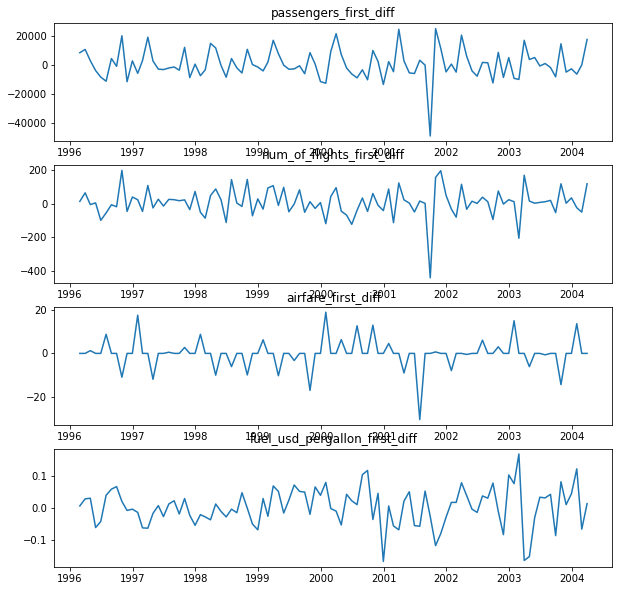

In [1441]:
# Plot our training data.
ts_model.plot();

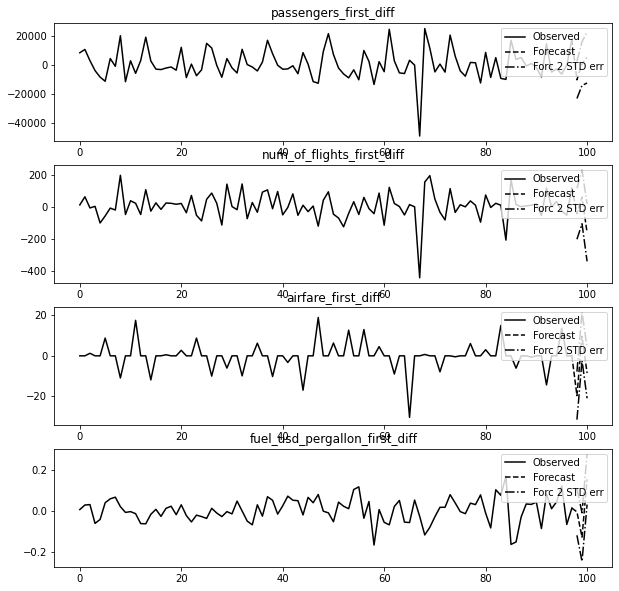

In [1442]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(3);

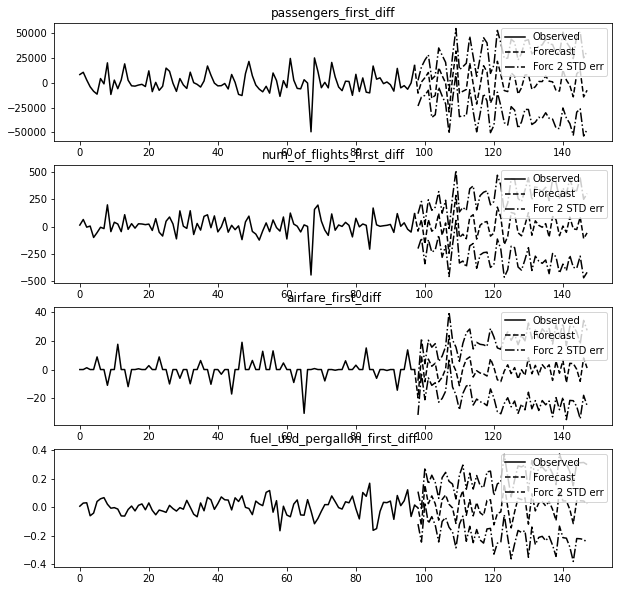

In [1443]:
# Plot the forecast looking 50 steps ahead.
ts_model.plot_forecast(50);

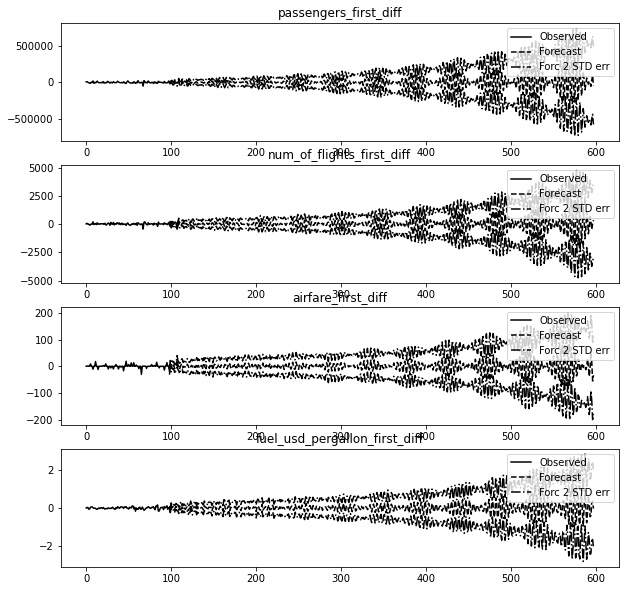

In [1444]:
# Plot the forecast looking 500 steps ahead.
ts_model.plot_forecast(500);

In [1445]:
# Generate a forecast one step ahead.
ts_model.forecast(train.values, 1) # (GDP, Population, Unemployment)

array([[-1.04248292e+04, -4.23208375e+01, -1.97151245e+01,
        -4.27469423e-03]])

In [1446]:
# Generate a forecast five steps ahead.
ts_model.forecast(train.values, 5)

array([[-1.04248292e+04, -4.23208375e+01, -1.97151245e+01,
        -4.27469423e-03],
       [ 7.95247244e+02,  6.20627691e+01,  9.68800787e+00,
        -1.26498027e-01],
       [ 5.10691383e+03, -1.60671401e+02, -8.50561660e+00,
         1.53746034e-01],
       [ 1.03290650e+04,  6.24888737e+01,  7.27865444e+00,
         2.50500788e-02],
       [-1.56852376e+04, -4.33097561e+01,  2.27685393e+00,
         7.90546217e-02]])

In [1447]:
# Generate a forecast that matches our testing set.
ts_model.forecast(train.values, len(test))

array([[-1.04248292e+04, -4.23208375e+01, -1.97151245e+01,
        -4.27469423e-03],
       [ 7.95247244e+02,  6.20627691e+01,  9.68800787e+00,
        -1.26498027e-01],
       [ 5.10691383e+03, -1.60671401e+02, -8.50561660e+00,
         1.53746034e-01],
       [ 1.03290650e+04,  6.24888737e+01,  7.27865444e+00,
         2.50500788e-02],
       [-1.56852376e+04, -4.33097561e+01,  2.27685393e+00,
         7.90546217e-02],
       [-1.25203978e+04, -1.82296776e+01,  4.41098165e+00,
         2.38920283e-02],
       [ 1.52654951e+04,  1.19774458e+02, -8.53233405e+00,
        -9.07674269e-02],
       [ 7.18805307e+03, -7.98876181e+01, -5.39654637e+00,
         5.39152658e-02],
       [-2.30202798e+02,  3.22303148e+01,  4.19833476e-01,
         8.58353462e-02],
       [-2.93969691e+04, -2.44794084e+02,  2.36676875e+01,
         2.02983359e-02],
       [ 4.80954181e+03,  4.91850974e+01,  4.28366953e+00,
        -4.86873717e-03],
       [ 3.19830064e+04,  2.84163663e+02, -9.78862184e-01,
      

In [1448]:
# See the values of our test set.
test.values

array([[ 1.6420e+03, -5.2000e+01, -8.6000e+00,  2.6000e-02],
       [ 2.0040e+03,  4.3000e+01,  0.0000e+00,  1.1900e-01],
       [ 4.0200e+02,  7.6000e+01,  0.0000e+00, -6.0000e-02],
       [ 1.0519e+04,  3.3300e+02, -3.0550e+01,  1.1300e-01],
       [-2.1260e+03,  1.5300e+02,  0.0000e+00,  8.2000e-02],
       [-1.8196e+04, -1.0000e+02,  0.0000e+00,  1.3500e-01],
       [ 2.2320e+04,  1.8000e+01, -2.4000e+00,  1.5800e-01],
       [-6.2350e+03, -2.0800e+02,  0.0000e+00, -1.7300e-01],
       [-5.3090e+03, -3.0000e+00,  0.0000e+00, -1.2400e-01],
       [-4.8200e+03, -8.8000e+01,  1.3730e+01,  1.1100e-01],
       [-3.5860e+03, -1.0900e+02,  0.0000e+00,  0.0000e+00],
       [ 2.8072e+04,  1.8300e+02,  0.0000e+00,  2.2800e-01],
       [-6.4120e+03, -4.7000e+01,  6.3600e+00,  1.1000e-02],
       [ 9.0810e+03,  6.6000e+01,  0.0000e+00, -1.0200e-01],
       [-1.3027e+04, -1.1500e+02,  0.0000e+00,  1.8300e-01],
       [ 5.1330e+03, -4.0000e+00, -2.6100e+00,  1.1000e-02],
       [-5.7060e+03,  3.

#### 6. Evaluate model (and forecasts, if possible).

In [1449]:
# We'll use MSE
from sklearn.metrics import mean_squared_error

In [1450]:
# Save forecasted values
forecast = ts_model.forecast(train.values, len(test))

In [1451]:
# Loop through columns and get MSE for each
for i in range(test.shape[1]):
    print(f'The test MSE on the {test.columns[i]} data is: {round(mean_squared_error(test.values[:, i], forecast[:, i]), 4)}')

The test MSE on the passengers_first_diff data is: 117412037.7071
The test MSE on the num_of_flights_first_diff data is: 13222.0769
The test MSE on the airfare_first_diff data is: 126.2588
The test MSE on the fuel_usd_pergallon_first_diff data is: 0.0461


In [1452]:
# Loop through columns and get RMSE for each - maybe more interpretable - don't compare to each other though
for i in range(test.shape[1]):
    print(f'The test RMSE on the {test.columns[i]} data is: {round(mean_squared_error(squared=False, y_true=test.values[:, i], y_pred=forecast[:, i]), 4)}')

The test RMSE on the passengers_first_diff data is: 10835.6835
The test RMSE on the num_of_flights_first_diff data is: 114.9873
The test RMSE on the airfare_first_diff data is: 11.2365
The test RMSE on the fuel_usd_pergallon_first_diff data is: 0.2146
